# physics724: Advanced Methods of Data Analysis

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE". Remember to delete the `raise NotImplementedError()` statements as you implement your solutions.

---

# Exercise 4.1: Reweighting with efficiencies

Let's say we have a Monte-Carlo simulation sample for a specific physics process at a particle collider experiment.

The sample is the result of generating collisions and decays, then simulating the detector response to the particles that interact with the sensors.

One important use of such simulation samples is to estimate the efficiency of reconstructing and selecting events of interest. Efficiencies usually cannot be inferred from the real data without already knowing how many events were produced in the first place, which is commonly the thing we are trying to measure.

However, the case may arise where the simulation does not faithfully reproduce the correct efficiency, or it may even not be simulated at all. This can be corrected by using a calibration sample of real data for a process that is already well-measured (thus the denominator of the efficiency is known in advance).

In the file `jpsi_mumu_data.csv` there is some kinematic information about a simulated sample of $J/\psi \to \mu^+ \mu^-$ decays. For your convenience, the data is opened in a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html#dataframe).

There are 1000 events in the dataset.
Here are the muon PTs in the first ten events.
mu+ PT [MeV]	mu- PT [MeV]
      1447.3	      1500.2
      1144.5	      1246.7
      2321.3	       914.5
      1181.7	      1784.7
       811.1	       811.8
      1598.8	      1577.2
      2688.7	       879.4
      1985.9	      1179.3
      2322.7	      1012.3
      1904.2	      1231.9

Here are the distributions of PT.


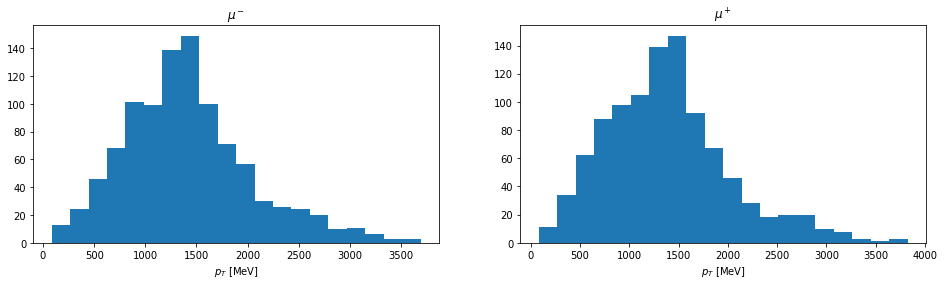

In [2]:
import pandas as pd

df = pd.read_csv("jpsi_mumu_data.csv")

n_evt = len(df)

print(f"There are {n_evt} events in the dataset.")

print("Here are the muon PTs in the first ten events.")
print("mu+ PT [MeV]\tmu- PT [MeV]")
for i_evt in range(10):
    mup_PT = df["muplus_PT"][i_evt]
    mum_PT = df["muminus_PT"][i_evt]
    print(f"{mup_PT:>12.1f}\t{mum_PT:>12.1f}")

from matplotlib import pyplot

fig, (h1,h2) = pyplot.subplots(1,2, figsize=(16,4))

print("\nHere are the distributions of PT.")

h1.hist(df["muminus_PT"], 20)
h2.hist(df["muplus_PT"], 20)
h1.set_title("$\mu^-$")
h2.set_title("$\mu^+$")
for h in h1,h2: h.set_xlabel("$p_T$ [MeV]")

We want to obtain the efficiency, and its uncertainty, of a trigger to select an event, where the trigger decision is not simulated. Instead we have a calibration sample represented by the 'histograms' below.

The array `muon_count_before` contains the total number of muons, $n$, in four bins of `p_T`, whose edges are given in the array `muon_pt_bins`. Likewise, the array `muon_count_after` contains the number of selected muons, $k$, in the same $p_T$ bins.

In reality, calibration samples are much larger than this. The numbers are fairly small in order to emulate the effect of taking a finely-binned histogram.

In [4]:
muon_count_before = [50, 30, 15, 9] # Total number of muons in the calibration sample in each bin of PT
muon_count_after  = [12, 14, 8, 7] # Number of selected muons in each bin of PT
muon_pt_bins = [0, 500, 1000, 2000, 10000] # Edges of the bins in PT

Your task is to calculate the efficiency of the trigger on this sample. Remember that an even can be selected if either or both muons 'fire' the trigger.

First, you should use the 'naive' method of calculating the probability of each event to pass and then take the mean probability over the entire sample as the efficiency.

Then use the method of obtaining ramdom weights for each event using the binomial model with a flat prior. Do this a large number of times (1000 should suffice) to build up a distribution of sums of weights. The mean of this distribution can be used to give an estimate of the efficiency, and the standard deviation can be used to give an estimate of the uncertainty on the efficiency.

*Hint:* You can use [scipy.stats.binom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html) but be aware that this gives $f(k)$ rather than $f(p)$.

*Hint:* Rather than loop through the dataset 1000 times, you may find it quicker to generate 1000 random values for each event.

In [40]:
#Naive Method
import numpy as np
import numpy.random as rand
mupl = df["muplus_PT"].to_numpy()
mumin = df["muminus_PT"].to_numpy()

mupl.sort()
mumin.sort()

event_numbers = [0,0,0,0]

for i_evt in range(len(mupl)):
        if mupl[i_evt] <500 or mumin[i_evt] <500:
                event_numbers[0]+=1
            
        elif mupl[i_evt] <1000 or mumin[i_evt] <1000:
            event_numbers[1]+=1

        elif mupl[i_evt] <2000 or mumin[i_evt] <2000:
            event_numbers[2]+=1

        elif mupl[i_evt] <10000 or mumin[i_evt] <10000:
            event_numbers[3]+=1

weighted = [event_numbers[i]*muon_count_after[i]/muon_count_before[i] for i in range(len(muon_count_after))]

naive_efficiency = np.sum(weighted)/len(mupl)
print('naive_efficiency = '+str(round(naive_efficiency,3)))

# for i in range(1000):
#     event_sel = [0 for i in range(len(muon_count_after))]

#     for i_evt in range(len(mupl)):
#         if mupl[i_evt] <500 or mumin[i_evt] <500:
#             if rand.uniform() < 12/50:
#                 event_sel.append(i_evt)
            
#         elif mupl[i_evt] <1000 or mumin[i_evt] <1000:
#             if rand.uniform() < 14/30:
#                 event_sel.append(i_evt)
            
#         elif mupl[i_evt] <2000 or mumin[i_evt] <2000:
#             if rand.uniform() < 8/15:
#                 event_sel.append(i_evt)

#         elif mupl[i_evt] <10000 or mumin[i_evt] <10000:
#             if rand.uniform() < 7/9:
#                 event_sel.append(i_evt)
#     efficiency_na.append(len(event_sel)/len(mupl))
# mean_naive_efficiency = np.mean(efficiency_na)
# error_naive_efficiency = np.std(efficiency_na)
# print('mean_naive_efficiency = '+str(mean_naive_efficiency) + ' +- ' + str(error_naive_efficiency))

naive_efficiency = 0.537


In [54]:
#weighted approach
#do not try to run. it takes too much time(more than a few hours)! I used accept reject method to sample efficiency(weights) from the binomial distribution with n = N_i (i is the ith bin), 
# k = calibrated efficiency * Ni. This is taking too much time. In the hindsight it should since we have n,k significatly large such that the binomial distribution resembles a narrow gaussian. The weight calculation is done 1000 times like it was asked.

import numpy as np
import numpy.random as rand
import math as math

def bino(n,k,e):
    binom = math.comb(n,k)
    binom *= (e**k)*((1-e)**(n-k))
    return binom

def accept_rej(n,k,j):
    max = bino(n,k,e=round(n/k))
    x = rand.uniform()
    y = rand.uniform(0,max)
    f_x = bino(n,k,x)
    if y<f_x:
        return x
    else:
        return 2


k_cal = [np.array(event_numbers)*np.array(muon_count_after)/np.array(muon_count_before)]
weight_sums = []

for i in range(1000):
    
    weights = []
    
    for j in range(len(event_numbers)):
        while(len(weights)<event_numbers[j]):
            wt = accept_rej(event_numbers[j],round(event_numbers[j]*muon_count_after[j]/muon_count_before[j]),j)
            if wt !=2:
                weights.append(wt)
        
    weight_sums.append(np.sum(weight_sums))

mean_weight = np.mean(weight_sums)
eff_binom = mean_weight/1000
err_eff_binom = np.std(mean_weight/1000)
print('Efficiency = %s +/- %s'%(eff_binom,err_eff_binom))

KeyboardInterrupt: 

Why is it valid to use the standard deviation to estimate the uncertainty on the efficiency?

Compare the results obtained from the two methods. What would happen with a much larger calibration sample?

ANSWER: Since we have large k and n, the binomial distribution resembles a gaussian one. so we can use standard deviation for the uncertainty. For a large calibration sample, the results from the two method should converge as the accuracy of the efficiency derived from the calibration sample increases.